In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [8]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

In [31]:
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes

In [35]:
# Separating the types of flares
classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(classical)) 

cmplx = len([i for i in complex_flag if i > 1.0]) 
print ("The number of complex flares : " + str(cmplx)) 

complex_flares = flare_table[flare_table['Complex flag'] == 2.0]
classical_flares = flare_table[flare_table['Complex flag'] == 1.0]

#-----------------------------------------------------------------------------------------
min_dur = 20.0 #minutes
max_dur = 75.0

dur_limit = len([i for i in flare_table['Flare_Duration'] if i >= min_dur and i<max_dur]) 
print ("The number of total flares with a duration between 20-75min : " + str(dur_limit))

#------------------------------------------------------------------------------------------
#adding in a column that is the flare duration into the table 
classical_flares['Flare_Duration'] = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
#classical_flares

print (len([i for i in classical_flares['Flare_Duration'] if i >= min_dur and i < max_dur]))

#------------------------------------------------------------------------------------------

#Table of Classical flares that are between 20-75 minutes as defined in Davenport(2014)

timed_classical = classical_flares[(classical_flares['Flare_Duration'] >= min_dur) & (classical_flares['Flare_Duration'] < max_dur)]
print(len(timed_classical))

The number of classical flares : 5162
The number of complex flares : 945
The number of total flares with a duration between 20-75min : 1641
902
902


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Importing in GJ1243 light curve (DR-25)

In [10]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

0 (39630, 7)
1 (39121, 7)
2 (45254, 7)
3 (45006, 7)
4 (43978, 7)
5 (39984, 7)
6 (32946, 7)
7 (34037, 7)
8 (44060, 7)
9 (42289, 7)
10 (39630, 5)
11 (46806, 7)


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


12 (39630, 5)


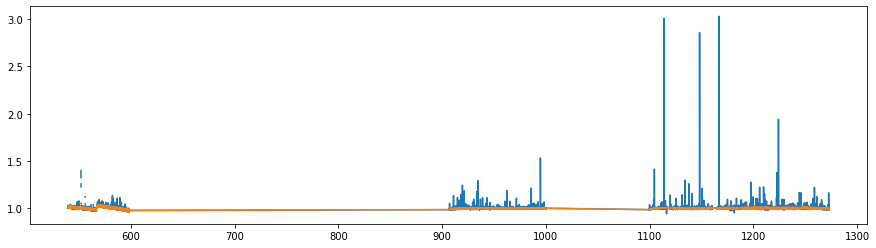

In [6]:
#Reading in the 11 mo gp files
from glob import glob

gp_files = glob('*.csv')

for k in range(len(gp_files)): 
    df_tmp = pd.read_csv(gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()

Text(0, 0.5, 'Flux')

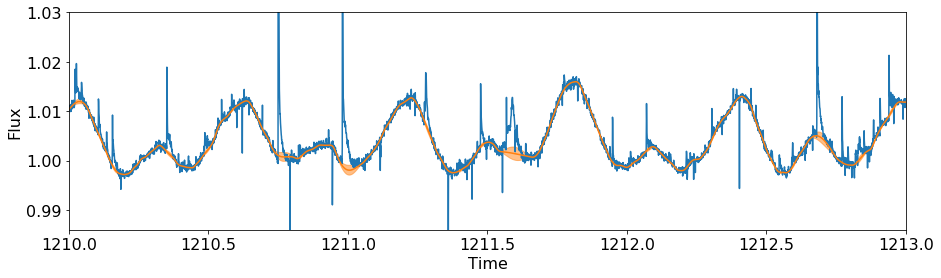

In [15]:
plt.figure(figsize=(15,4))
font = {'size'   : 16}
plt.rc('font', **font)
color = "#ff7f0e"
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.fill_between(df['time'], df['mean']+df['std'], df['mean']-df['std'],color=color, alpha=0.5,
                 edgecolor="none",label='gp')

plt.xlim(1210,1213)
plt.ylim(.986,1.03)
plt.xlabel("Time")
plt.ylabel("Flux")

In [38]:
#print((df['detrended_flux']))#has NaNs why?
#print(len(df['time']))

### Interpolating over full light curve

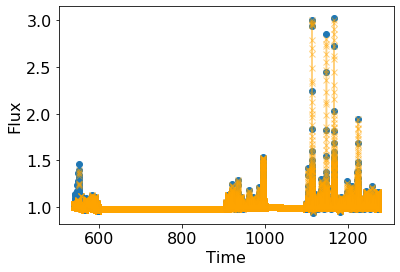

In [27]:
#interpolating the full light curve
plt.scatter(df['time'],df['detrended_flux'])

plt.xlabel("Time")
plt.ylabel("Flux")

padding_factor = 10
steps = padding_factor*len(df['detrended_flux'])

xvals = np.linspace(539.460, 1273.07, steps)
yinterp = np.interp(xvals, df['time'], df['detrended_flux'])
plt.plot(xvals,yinterp,'-x',color='orange',alpha=0.5)

#### Finding the flux and time values where local maxes occur w/in interpolated data (i.e where the flares happen)

In [37]:
time_max = np.array([])
peaks = np.array([])
t_halfs = np.array([])
for i in range(0,len(timed_classical)):
    temp = np.where((xvals < timed_classical['t_stop'].values[i]) & 
                    (xvals > timed_classical['t_start'].values[i]))[0]
    i_max = np.argmax(yinterp[temp])
    t_max = (xvals[temp][i_max])
    flux_max = (yinterp[temp][i_max])
    time_max = np.append(time_max,t_max)
    peaks = np.append(peaks,flux_max)
    half_peaks = peaks/2.0
    i_xs = np.where((yinterp[temp] > half_peaks[i]))[0]
    time_xs = xvals[temp][i_xs]
    t_half = max(time_xs) - min(time_xs)
    t_halfs = np.append(t_halfs,t_half)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


ValueError: max() arg is an empty sequence

In [50]:
print(len(timed_classical))

902


In [54]:
#x = x[~numpy.isnan(x)]
print((~np.isnan(yinterp)))

[ True False False ...  True  True  True]


### Plotting the Stacked Flares

In [ ]:
for i in range(0,len(timed_classical)):
        x = (df['time'] - time_max[i])/(t_halfs[i])
        y = ((df['detrended_flux'])/(peaks[i]))
        plt.plot(x,y,color='b',alpha=0.1)



        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        #plt.ylim(-0.4,1)
        plt.xlim(-10,20)
        plt.ylim(-0.4,1)